# Extra Credit Project Linkage Clustering with L2, L1 , jacobian, correlation, cosine, jaccard, jaccard coefficient distance(without inbuilt libraries)
## by Pritam Channawar

# Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
#conda install hclust2=1.0.0

In [2]:
from __future__ import division
import numpy as np

# The Lance-Williams algorithms
In the naive implementation of agglomerative hierarchical clustering, you compute the distance matrix between each cluster at each step. The Lance-Williams algorithms are a family of agglomerative hierarchical clustering algorithms which are represented by a recursive formula for computing cluster distances at each step. Any hierarchical clustering technique that can be expressed using the Lance-Williams formula does not need to keep the original data points.

We’ll use Wikipedia’s notation here. Suppose that C_i, C_j are the next clusters to be merged. Let d_{ij} be the distance (using any method discussed above) between C_i and C_j. Further, let d_{(ij)k} be the distance between the merged cluster C_i \cup C_j and cluster C_k. An algorithm belongs to the Lance-Williams family if the distance d_{(ij)k} can be recursively computed as

d_{(ij)k} = \alpha_i d_{ik} + \alpha_j d_{jk} + \beta d_{ij} + \gamma \left\vert d_{ik}-d_{jk} \right\vert

All the methods we discussed above belong to the Lance-Williams family. This table summarizes the coefficient values.

# Implementing hierarchical clustering
Now let’s implement hierarchical clustering. We’ll use the Lance-Williams formula.

# Functions for clustering and dendrogram  

In [3]:
#This function is used to update the distance matrix in the clustering procedure.

def _general_link(clusters, i, j, method):
    for k in range(len(clusters)):
        if k != i and k != j:
            if method.__name__ == "ward_update":
                new_distance = method(clusters[i,k], clusters[j,k], k)
            else:
                new_distance = method(clusters[i,k], clusters[j,k])
            clusters[i,k] = new_distance
            clusters[k,i] = new_distance
    return clusters

In [4]:
def single_link(clusters, i, j, dendrogram):
    ks = np.arange(clusters.shape[0])
    ks = ks[(ks!=i) & (ks!=j)]
    minima = np.minimum(clusters[i,], clusters[j,])[ks]
    clusters[i,ks] = minima
    clusters[ks,i] = minima
    return clusters
    # return _general_link(clusters, i, j, min)

Hierarchical Agglomerative Clustering using single linkage. Cluster j is
clustered with cluster i when the minimum distance between any
of the members of i and j is the smallest distance in the vector space.
    Lance-Williams parameters:
    M{S{alpha}(i) = 0.5; S{beta} = 0; S{gamma} = -0.5} which equals
    M{min(d(i,k),d(j,k))}
    

In [5]:
def complete_link(clusters, i, j, dendrogram):
    ks = np.arange(clusters.shape[0])
    ks = ks[(ks!=i) & (ks!=j)]
    maxima = np.maximum(clusters[i,], clusters[j,])[ks]
    clusters[i,ks] = maxima
    clusters[ks,i] = maxima
    return clusters
    # return _general_link(clusters, i, j, max)

Hierarchical Agglomerative Clustering using complete linkage. Cluster j is clustered with cluster i when the maximum distance between any of the members of i and j is the smallest distance in the vector space. Lance-Williams parameters:
    M{S{alpha}(i) = 0.5; S{beta} = 0; S{gamma} = 0.5} which equals 
    M{max(d(i,k),d(j,k))}
    

In [6]:
def WPGMA_link(clusters, i, j, dendrogram):
    update_fn = lambda d_ik,d_jk: (d_ik + d_jk) / 2
    return _general_link(clusters, i, j, update_fn)

Hierarchical Agglomerative Clustering using weighted linkage called as WPGMA(Weighted Pair Group Method with Arithmetic Mean). Cluster j is clustered with cluster i when the mean of distance between any of the members of i and j is the average distance in the vector space. Lance-Williams parameters: M{S{alpha}(i) = 0.5;S{alpha}(j) = 0.5; S{beta} = 0; S{gamma} = 0} which equals M{(d(i,k)+d(j,k)/2}

In [7]:
def UPGMA_link(clusters, i, j, dendrogram):
    n_i, n_j = len(dendrogram[i]), len(dendrogram[j])
    a_i = n_i / (n_i + n_j)
    a_j = n_j / (n_i + n_j)
    update_fn = lambda d_ik,d_jk: a_i*d_ik + a_j*d_jk
    return _general_link(clusters, i, j, update_fn)

Hierarchical Agglomerative Clustering using group average linkage also known as UPGMA(nweighted pair group method with arithmetic mean). Cluster j is clustered with cluster i when the pairwise average of values between the clusters is the smallest in the vector space.
    Lance-Williams parameters:
    M{S{alpha}(i) = |i|/(|i|+|j|); S{beta} = 0; S{gamma} = 0}
    

In [8]:
def median_link(clusters, i, j, dendrogram):
    update_fn = lambda d_ik,d_jk: 0.5*d_ik + 0.5*d_jk + -0.25*clusters[i,j]
    return _general_link(clusters, i, j, update_fn)

Hierarchical Agglomerative Clustering using median linkage. Cluster j is clustered with cluster i when the distance between the median values of the clusters is the smallest in the vector space. Lance-Williams parameters:
    M{S{alpha}(i) = 0.5; S{beta} = -0.25; S{gamma} = 0}

In [9]:
def PDLM_link(clusters, i, j, dendrogram):
    n_i, n_j = len(dendrogram[i]), len(dendrogram[j])
    a_i = n_i / (n_i + n_j)
    a_j = n_j / (n_i + n_j)
    b = -(n_i * n_j) / pow((n_i + n_j),2)
    update_fn = lambda d_ik,d_jk: a_i*d_ik + a_j*d_jk + b*clusters[i,j]
    return _general_link(clusters, i, j, update_fn)

Hierarchical Agglomerative Clustering using centroid linkage also called as prototype distance linkage mean. Cluster j is clustered with cluster i when the distance between the centroids of the clusters is the smallest in the vector space.
    Lance-Williams parameters:
    M{S{alpha}(i) = |i| / (|i| + |j|); S{beta} = -|i||j| / (|i|+ |j|)^2; 
    S{gamma} = 0}

In [10]:
def ward_link(clusters, i, j, dendrogram):
    n_i, n_j = len(dendrogram[i]), len(dendrogram[j])
    def ward_update(d_ik, d_jk, k):
        n_k = len(dendrogram[k])
        n_ijk = n_i+n_j+n_k
        return ( (n_i+n_k)/(n_ijk)*d_ik + (n_j+n_k)/(n_ijk)*d_jk +
                 -(n_k/(n_ijk))*clusters[i][j] )
    return _general_link(clusters, i, j, ward_update)

Hierarchical Agglomerative Clustering using Ward's linkage. Two clusters i and j are merged when their merge results in the smallest increase in the sum of error squares in the vector space.
    Lance-Williams parameters:
    M{S{alpha}(i) = (|i| + |k|) / (|i| + |j| + |k|); 
    S{beta} = -|k|/(|i| + |j| + |k|); S{gamma} = 0}

In [11]:
LINKAGES = {'ward': ward_link, 
            'complete': complete_link,
            'single': single_link,
            'PDLM': PDLM_link,
            'UPGMA': UPGMA_link,
            'median': median_link,
           'WPGMA': WPGMA_link}

In [12]:
def linkage_fn(linkage):
    if linkage in LINKAGES:
        return LINKAGES[linkage]
    raise ValueError("Linkage funtion '%s' is not supported" % linkage)

__all__ = ['single_link', 'complete_link', 'PDLM_link', 'ward_link',
           'median_link', 'UPGMA_link', 'WPGMA_link']

In [13]:
import copy
import sys
import numpy as np

import numpy

from operator import itemgetter

class DendrogramNode(object):
    #Represents a node in a dendrogram
    def __init__(self, id, *children):
        self.id = id
        self.distance = 0.0
        self._children = children

    def leaves(self):
    #Return the leaves of all children of a given node
        if self._children:
            leaves = []
            for child in self._children:
                leaves.extend(child.leaves())
            return leaves
        else:
            return [self]

    def adjacency_list(self):
#For each merge in the dendrogram, return the direct children of the cluster, 
#the distance between them and the number of items in the cluster.
        
        if self._children:
            a_list = [(self.id, self._children[0].id, self._children[1].id,
                       self.distance, len(self))]
            for child in self._children:
                a_list.extend(child.adjacency_list())
            return a_list
        else: return []

    def __len__(self):
        return len(self.leaves())

In [14]:
class Dendrogram(list):
    
    def __init__(self, items):
        super(Dendrogram, self).__init__(map(DendrogramNode, range(len(items))))
        self._num_items = len(self)

    def merge(self, *indices):
        
        #Merge two or more nodes at the given INDICES in the dendrogram.
        #The new node will get the index of the first node specified.
        
        assert len(indices) >= 2
        node = DendrogramNode(
            self._num_items, *[self[i] for i in indices])
        self._num_items += 1
        self[indices[0]] = node
        for i in indices[1:]:
            del self[i]

    def to_linkage_matrix(self):
        Z = self[0].adjacency_list()
        Z.sort()
        Z = numpy.array(Z)
        return Z[:,1:]

    def draw(self, show=True, save=False, format="pdf", labels=None, title=None, fontsize=None):
        #Draw the dendrogram using pylab and matplotlib.
        try:
            from scipy.cluster.hierarchy import dendrogram as scipy_dendrogram
        except ImportError:
            raise ImportError("Scipy not installed, can't draw dendrogram")
        try:
            import pylab
        except ImportError:
            raise ImportError("Pylab not installed, can't draw dendrogram")
        try:
            import matplotlib.pyplot as plt
        except ImportError:
            raise ImportError("Matplotlib not installed, can't draw dendrogram")

        fig = plt.figure()
        ax = fig.add_subplot(111, fc='white')

        plt.rcParams['font.family'] = 'arial'
        plt.rcParams['font.size'] = 6
        plt.rcParams['lines.linewidth'] = 0.75

        m = self.to_linkage_matrix()

        d = scipy_dendrogram(m, labels=labels,
                             leaf_font_size=fontsize,
                             color_threshold=0.7*max(m[:,2]),
                             leaf_rotation=180)

        ax = plt.gca()
        ax_labels = ax.get_xmajorticklabels()+ax.get_ymajorticklabels()
        for i in range(len(ax_labels)):
            ax_labels[i].set_family('arial')

        ax.get_yaxis().set_ticks([])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        plt.xticks(rotation=90)

        plt.tick_params(axis='x', which='both', bottom='off', top='off')
        plt.tick_params(axis='y', which='both', bottom='off', top='off')
        ax.xaxis.grid(False)
        ax.yaxis.grid(False)

        plt.rcParams["figure.facecolor"] = "white"
        plt.rcParams["axes.facecolor"] = "white"
        plt.rcParams["savefig.facecolor"] = "white"

        if title is not None:
            fig.suptitle(title, fontsize=12)
        if show:
            fig.show()
        if save:
            fig.savefig('dendrogram.%s' % (format,))

    def ete_tree(self, labels=None):
        if sys.version_info[0] == 2:
            from ete2 import Tree, NodeStyle, TreeStyle
        elif sys.version_info[0] == 3:
            from ete3 import Tree, NodeStyle, TreeStyle
        else:
            raise ValueError('Your version of Python is not supported.')

        from scipy.cluster.hierarchy import to_tree

        T = to_tree(self.to_linkage_matrix())
        root = Tree()
        root.dist = 0
        root.name = "root"
        item2node = {T: root}
        to_visit = [T]
        while to_visit:
            node = to_visit.pop()
            cl_dist = node.dist / 2.0
            for ch_node in [node.left, node.right]:
                if ch_node:
                    ch = Tree()
                    ch.dist = cl_dist
                    ch.name = str(ch_node.id)
                    item2node[node].add_child(ch)
                    item2node[ch_node] = ch
                    to_visit.append(ch_node)
        if labels != None:
            for leaf in root.get_leaves():
                leaf.name = str(labels[int(leaf.name)])

        ts = TreeStyle()
        ts.show_leaf_name = True

        # Draws nodes as small red spheres of diameter equal to 10 pixels
        nstyle = NodeStyle()
        nstyle["shape"] = None
        nstyle["size"] = 0

        # Gray dashed branch lines
        nstyle["hz_line_type"] = 1
        nstyle["hz_line_color"] = "#cccccc"

        # Applies the same static style to all nodes in the tree. Note that,
        # if "nstyle" is modified, changes will affect to all nodes
        for n in root.traverse():
           n.set_style(nstyle)
        return root

In [15]:
import numpy
from numpy import dot, sqrt

def cosine_distance(u, v, binary=False):
    """Return the cosine distance between two vectors."""
    if binary:
        return cosine_distance_binary(u, v)
    return 1.0 - dot(u, v) / (sqrt(dot(u, u)) * sqrt(dot(v, v)))
    
def cosine_distance_binary(u, v):
    u = binarize_vector(u)
    v = binarize_vector(v)
    return (1.0 * (u * v).sum()) / numpy.sqrt((u.sum() * v.sum()))

def euclidean_distance(u, v):
    """Return the euclidean distance between two vectors."""
    diff = u - v
    return sqrt(dot(diff, diff))

def manhattan_distance(u, v):
    """Return the Manhattan/City Block distance between two vectors."""
    return abs(u-v).sum()

def canberra_distance(u, v):
    """Return the canberra distance between two vectors."""
    return numpy.sum(abs(u-v) / abs(u+v))

def correlation(u, v):
    """Return the correlation distance between two vectors."""
    u_var = u - u.mean()
    v_var = v - v.mean()
    return 1.0 - dot(u_var, v_var) / (sqrt(dot(u_var, u_var)) *
                                      sqrt(dot(v_var, v_var)))

def dice(u, v):
    """Return the dice coefficient between two vectors."""
    u = u > 0
    v = v > 0
    return (2.0 * (u * v).sum()) / (u.sum() + v.sum())

def jaccard_distance(u, v):
    """return jaccard distance"""
    u = numpy.asarray(u)
    v = numpy.asarray(v)
    return (numpy.double(numpy.bitwise_and((u != v),
            numpy.bitwise_or(u != 0, v != 0)).sum())
            /  numpy.double(numpy.bitwise_or(u != 0, v != 0).sum()))

def jaccard(u, v):
    """Return the Jaccard coefficient between two vectors."""
    u = u > 0
    v = v > 0
    return (1.0 * (u * v).sum()) / (u + v).sum() 

In [16]:
import string

class Text(object):
    def __init__(self, id, title, author, year, text, kind=None):
        self._id = id
        self._text = text
        self._title = title
        self._author = author
        self._year = int(year)
        self._kind = kind
        # remove all punctuation, transform to lowercase and split on spaces
        self._tokens = text.translate(None, string.punctuation).lower().split()

    def __hash__(self): # IS THIS ALLOWED?
        return self._id

    def title(self): return self._title
    def author(self): return self._author
    def year(self): return self._year
    def kind(self): return self._kind

    def __getitem__(self, i):
        if isinstance(i, slice):
            return self._tokens[i.start:i.stop]
        else:
            return self._tokens[i]

    def __len__(self):
        return len(self._tokens)

In [17]:
class AbstractClusterer(object):
    
    #Abstract interface covering basic clustering functionality.
    
    def __init__(self, data, linkage, num_clusters):
        
        raise AssertionError('AbstractClusterer is an abstract interface')
        
    def iterate_clusters(self):

        #Iterate over all unique vector combinations in the matrix.
        
        raise AssertionError('AbstractClusterer is an abstract interface')
        
    def smallest_distance(self, clusters):
        
        #Return the smallest distance in the distance matrix.
        #The smallest distance depends on the possible connections in the distance matrix.
        
        raise AssertionError('AbstractClusterer is an abstract interface')
        
    def cluster(self, verbose=0, sum_ess=False):

        #Cluster all clusters hierarchically unitl the level of 
        #num_clusters is obtained.
        
        raise AssertionError('AbstractClusterer is an abstract interface')
        
    def update_distmatrix(self, i, j, clusters):
       
        #Update the distance matrix using the specified linkage method, so that
        #it represents the correct distances to the newly formed cluster.
        
        return self.linkage(clusters, i, j, self._dendrogram)
        
    def dendrogram(self):
        
        #Return the dendrogram object.
        
        return self._dendrogram
        
    def num_clusters(self):
        
        #Return the number of clusters.
        
        return self._num_clusters

In [18]:
from __future__ import division
from __future__ import absolute_import

import numpy
import copy
import argparse

from operator import itemgetter
from collections import defaultdict
from itertools import combinations, product

from sklearn.metrics.pairwise import pairwise_distances

In [19]:
class CooccurrenceMatrix(numpy.ndarray):
    # Represents a co-occurrence matrix.
    def __new__(cls, data, dtype=None):
        if not isinstance(data, CooccurrenceMatrix):
            data, rownames, colnames = CooccurrenceMatrix.convert(data)
        else:
            rownames, colnames = data.rownames, data.colnames
        obj = numpy.asarray(data).view(cls)
        obj.rownames = rownames
        obj.colnames = colnames
        return obj

    def __array_finialize__(self, obj):
        if obj is None: return
        self.rownames = getattr(obj, 'rownames', None)
        self.colnames = getattr(obj, 'colnames', None)

    def row(self, row):
        return self[self.rownames.get(row)]

    def col(self, col):
        return self[:,self.colnames.get(col)]

    def cell(self, row, col):
        return self[self.rownames.get(row), self.colnames.get(col)]

    @classmethod
    def convert(cls, data):
        matrix = numpy.zeros((len(set(k for k,v in data)),
                              len(set(v for k,v in data))))
        colnames, rownames = {}, {}
        for k,v in sorted(data):
            if k not in rownames:
                rownames[k] = len(rownames)
            if v not in colnames:
                colnames[v] = len(colnames)
            matrix[rownames[k],colnames[v]] += 1
        #rownames = [k for k,v in sorted(rownames.items(), key=itemgetter(1))]
        #colnames = [k for k,v in sorted(colnames.items(), key=itemgetter(1))]
        return matrix, rownames, colnames

    def tfidf(self):
        
       # Returns a matrix in which for all entries in the co-occurence matrix
        #the 'term frequency-inverse document frequency' is calculated.
        
        matrix = numpy.zeros(self.shape)
        # the number of words in a document
        words_per_doc = numpy.asarray(self.sum(axis=1), dtype=float)
        # the number of documents in which a word is attested.
        word_frequencies = numpy.asarray(numpy.sum(self > 0, axis=0), dtype=float)
        # calculate the term frequencies
        for i in range(self.shape[0]):
            tf = self[i] / words_per_doc[i] # array of tf's
            matrix[i] = tf * (numpy.log(self.shape[0] / word_frequencies))
        return matrix

In [20]:
class DistanceMatrix(numpy.ndarray):
    
    #Simple wrapper around numpy.ndarray, to provide some custom
    #Distance Matrix functionality like plotting the distance matrix
    #with matplotlib.
    
    def __new__(cls, data, dist_metric=euclidean_distance, lower=True):
        if (not isinstance(data, (numpy.ndarray, DistanceMatrix))
            or len(data) != len(data[0])
            or not max(numpy.diag(data)) == 0):
            data = DistanceMatrix.convert_to_distmatrix(data, dist_metric, lower=lower)
        obj = numpy.asarray(data).view(cls)
        obj.distance_metric = dist_metric
        return obj

    def __array_finialize__(self, obj):
        if obj is None: return
        self.distance_metric = getattr(obj, 'distance_metric', None)

    def row(self, row):
        return self[self.rownames.get(row)]

    def col(self, col):
        return self[:,self.colnames.get(col)]

    def cell(self, row, col):
        return self[self.rownames.get(row), self.colnames.get(col)]

    def rows(self):
        return [k for k,v in sorted(self.rownames.items(), key=itemgetter(1))]

    @classmethod
    def convert_to_distmatrix(cls, data, distance, lower=True):
        matrix = numpy.zeros((len(data), len(data)))
        for i,j in combinations(range(len(data)), 2):
            matrix[i][j] = distance(data[i], data[j])
            if lower == True:
                matrix[j][i] = matrix[i][j]
        # add a nan-diagonal, useful for further computations.
        numpy.fill_diagonal(matrix, numpy.nan)
        return matrix

    def diag_is_zero(self):
        #Check if the diagonal contains only distances of 0
        return max(numpy.diag(self)) == 0

    def remove(self, idx):
        
        #Delete a row and column with index IDX.
        
        indices = range(len(self))
        indices.remove(idx)
        return self.take(indices, axis=0).take(indices, axis=1)

    def summary(self):
        #Return a small summary of the matrix
        print('DistanceMatrix (n=%s)' % len(self))
        print('Distance metric = %s' % self.distance_metric.__name__)
        print(self)

In [21]:
class Clusterer(AbstractClusterer):
    
    #The Hierarchical Agglomerative Clusterer starts with each of the N vectors
   #as singleton clusters. This continues until there is only one cluster.
    
    def __init__(self, data, linkage='ward', num_clusters=1):
        self._num_clusters = num_clusters
        vector_ids = [[i] for i in range(len(data))]
        self._dendrogram = Dendrogram(vector_ids)
        numpy.fill_diagonal(data, numpy.inf)
        self._dist_matrix = data
        self.linkage = linkage_fn(linkage)

    def smallest_distance(self, clusters):
        
        #Return the smallest distance in the distance matrix.
        #The smallest distance depends on the possible connections in
        #the distance matrix.
        
        i, j = numpy.unravel_index(numpy.argmin(clusters), clusters.shape)
        return clusters[i, j], i, j

    def cluster(self, verbose=0, sum_ess=False):
        
        #Cluster all clusters hierarchically until the level of
        #num_clusters is obtained.
        
        clusters = copy.copy(self._dist_matrix)
        #clusters = self._dist_matrix
        summed_ess = 0.0

        while len(clusters) > max(self._num_clusters, 1):
            if verbose >= 1:
                print('k=%s' % len(clusters))
                if verbose == 2:
                    print(clusters)

            best, i, j = self.smallest_distance(clusters)
            # In Ward (1963) ess is summed at each iteration
            # in R's hclust and Python's hcluster and some text books it is not.
            # Here it is optional...
            if sum_ess:
                summed_ess += best
            else:
                summed_ess = best
            clusters = self.update_distmatrix(i, j, clusters)
            self._dendrogram.merge(i,j)
            self._dendrogram[i].distance = summed_ess
            indices = numpy.arange(clusters.shape[0])
            indices = indices[indices!=j]
            clusters = clusters.take(indices, axis=0).take(indices, axis=1)

    def update_distmatrix(self, i, j, clusters):
        
        #Update the distance matrix using the specified linkage method so that
        #it represents the correct distances to the newly formed cluster.
        
        return self.linkage(clusters, i, j, self._dendrogram)

    @property
    def dendrogram(self):
        #Return the dendrogram object.
        return self._dendrogram

    def num_clusters(self):
        return self._num_clusters

    def __repr__(self):
        return """<Hierarchical Agglomerative Clusterer(linkage method: %r,
                  n=%d clusters>""" % (self.linkage.__name__, self._num_clusters)


In [22]:
class VNClusterer(Clusterer):
    def __init__(self, data, linkage='ward', num_clusters=1):
        Clusterer.__init__(self, data, linkage, num_clusters=num_clusters)

    def iterate_clusters(self, clusters):
        for i in range(1, len(clusters)):
            yield i-1,i

    def smallest_distance(self, clusters):
        best = None
        for i, j in self.iterate_clusters(clusters):
            if best is None or clusters[i][j] <= best[0]:
                best = (clusters[i][j], i, j)
        return best

    def cluster(self, verbose=False):
        # we must sum the error sum of squares in order not to obtain
        # singleton clustering.
        Clusterer.cluster(self, verbose=verbose, sum_ess=True)

Variability Neighbor Clustering Class. A subclass of the regular Clusterer where the order of clustering can be predetermined. In the normal clustering procedure, all clusters can be clustered with all other clusters. In this class, the clusters that are allowed to be clustered follow a specific order.
    

In [23]:
class EuclideanNeighborClusterer(VNClusterer):

    def iterate_clusters(self, x, y):
        n_features, n_samples = x, y
        offset = (0, -1, 1)
        indices = ((i, j) for i in range(n_features) for j in range(n_samples))
        for i, j in indices:
            all_neigh = ((i + x, j + y) for x in offset for y in offset)
            valid = ((i*n_features + j) for i, j in all_neigh if (0 <= i < n_features) and (0 <= j < n_samples))
            target = valid.next()
            for neighbor in list(valid):
                yield target, neighbor

# Apply linkage clustering functions on given dataset

# Clustering with (L2)Euclidean Distance

In [24]:
vectors = numpy.array([[4,4], [8,4], [15,8], [24,4], [24,12]])
dist_matrix = DistanceMatrix(vectors, euclidean_distance)

## Single Linkage

In [25]:
clusterer = Clusterer(dist_matrix, linkage='single')
clusterer.cluster(verbose=2)

k=5
[[        inf  4.         11.70469991 20.         21.54065923]
 [ 4.                 inf  8.06225775 16.         17.88854382]
 [11.70469991  8.06225775         inf  9.8488578   9.8488578 ]
 [20.         16.          9.8488578          inf  8.        ]
 [21.54065923 17.88854382  9.8488578   8.                 inf]]
k=4
[[        inf  8.06225775 16.         17.88854382]
 [ 8.06225775         inf  9.8488578   9.8488578 ]
 [16.          9.8488578          inf  8.        ]
 [17.88854382  9.8488578   8.                 inf]]
k=3
[[        inf  8.06225775 16.        ]
 [ 8.06225775         inf  9.8488578 ]
 [16.          9.8488578          inf]]
k=2
[[      inf 9.8488578]
 [9.8488578       inf]]


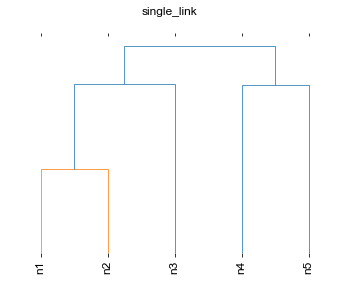

In [26]:
labels = ['n'+str(i+1) for i in range(len(vectors))]
clusterer.dendrogram.draw(title=clusterer.linkage.__name__, labels=labels)

## Complete Linkage

In [27]:
clusterer = Clusterer(dist_matrix, linkage='complete')
clusterer.cluster(verbose=2)

k=5
[[        inf  4.         11.70469991 20.         21.54065923]
 [ 4.                 inf  8.06225775 16.         17.88854382]
 [11.70469991  8.06225775         inf  9.8488578   9.8488578 ]
 [20.         16.          9.8488578          inf  8.        ]
 [21.54065923 17.88854382  9.8488578   8.                 inf]]
k=4
[[        inf 11.70469991 20.         21.54065923]
 [11.70469991         inf  9.8488578   9.8488578 ]
 [20.          9.8488578          inf  8.        ]
 [21.54065923  9.8488578   8.                 inf]]
k=3
[[        inf 11.70469991 21.54065923]
 [11.70469991         inf  9.8488578 ]
 [21.54065923  9.8488578          inf]]
k=2
[[        inf 21.54065923]
 [21.54065923         inf]]


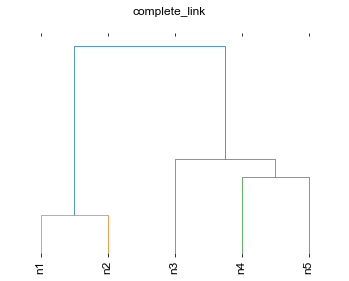

In [28]:
labels = ['n'+str(i+1) for i in range(len(vectors))]
clusterer.dendrogram.draw(title=clusterer.linkage.__name__, labels=labels)

## UPGMA Linkage

In [29]:
clusterer = Clusterer(dist_matrix, linkage='UPGMA')
clusterer.cluster(verbose=2)

k=5
[[        inf  4.         11.70469991 20.         21.54065923]
 [ 4.                 inf  8.06225775 16.         17.88854382]
 [11.70469991  8.06225775         inf  9.8488578   9.8488578 ]
 [20.         16.          9.8488578          inf  8.        ]
 [21.54065923 17.88854382  9.8488578   8.                 inf]]
k=4
[[        inf  9.88347883 18.         19.71460152]
 [ 9.88347883         inf  9.8488578   9.8488578 ]
 [18.          9.8488578          inf  8.        ]
 [19.71460152  9.8488578   8.                 inf]]
k=3
[[        inf  9.88347883 18.85730076]
 [ 9.88347883         inf  9.8488578 ]
 [18.85730076  9.8488578          inf]]
k=2
[[        inf 15.86602678]
 [15.86602678         inf]]


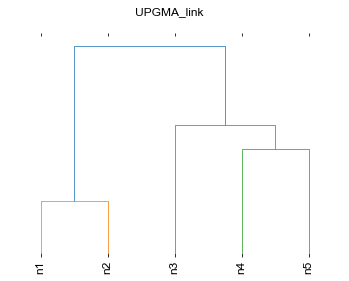

In [30]:
labels = ['n'+str(i+1) for i in range(len(vectors))]
clusterer.dendrogram.draw(title=clusterer.linkage.__name__, labels=labels)

## Median Linkage

In [31]:
clusterer = Clusterer(dist_matrix, linkage='median')
clusterer.cluster(verbose=2)

k=5
[[        inf  4.         11.70469991 20.         21.54065923]
 [ 4.                 inf  8.06225775 16.         17.88854382]
 [11.70469991  8.06225775         inf  9.8488578   9.8488578 ]
 [20.         16.          9.8488578          inf  8.        ]
 [21.54065923 17.88854382  9.8488578   8.                 inf]]
k=4
[[        inf  8.88347883 17.         18.71460152]
 [ 8.88347883         inf  9.8488578   9.8488578 ]
 [17.          9.8488578          inf  8.        ]
 [18.71460152  9.8488578   8.                 inf]]
k=3
[[        inf  8.88347883 15.85730076]
 [ 8.88347883         inf  7.8488578 ]
 [15.85730076  7.8488578          inf]]
k=2
[[        inf 10.40817535]
 [10.40817535         inf]]


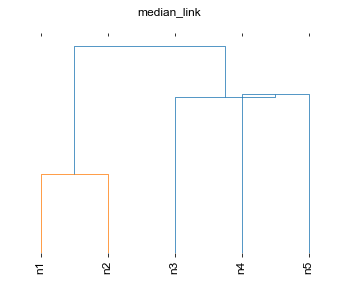

In [32]:
labels = ['n'+str(i+1) for i in range(len(vectors))]
clusterer.dendrogram.draw(title=clusterer.linkage.__name__, labels=labels)

## PDLM Linkage

In [33]:
clusterer = Clusterer(dist_matrix, linkage='PDLM')
clusterer.cluster(verbose=2)

k=5
[[        inf  4.         11.70469991 20.         21.54065923]
 [ 4.                 inf  8.06225775 16.         17.88854382]
 [11.70469991  8.06225775         inf  9.8488578   9.8488578 ]
 [20.         16.          9.8488578          inf  8.        ]
 [21.54065923 17.88854382  9.8488578   8.                 inf]]
k=4
[[        inf  8.88347883 17.         18.71460152]
 [ 8.88347883         inf  9.8488578   9.8488578 ]
 [17.          9.8488578          inf  8.        ]
 [18.71460152  9.8488578   8.                 inf]]
k=3
[[        inf  8.88347883 15.85730076]
 [ 8.88347883         inf  7.8488578 ]
 [15.85730076  7.8488578          inf]]
k=2
[[        inf 11.78850283]
 [11.78850283         inf]]


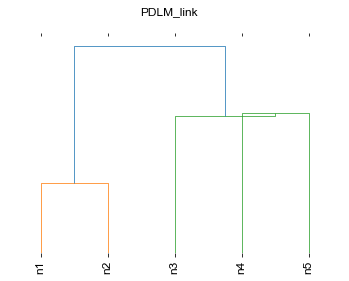

In [34]:
labels = ['n'+str(i+1) for i in range(len(vectors))]
clusterer.dendrogram.draw(title=clusterer.linkage.__name__, labels=labels)

## Ward Linkage

In [35]:
clusterer = Clusterer(dist_matrix, linkage='ward')
clusterer.cluster(verbose=2)

k=5
[[        inf  4.         11.70469991 20.         21.54065923]
 [ 4.                 inf  8.06225775 16.         17.88854382]
 [11.70469991  8.06225775         inf  9.8488578   9.8488578 ]
 [20.         16.          9.8488578          inf  8.        ]
 [21.54065923 17.88854382  9.8488578   8.                 inf]]
k=4
[[        inf 11.84463844 22.66666667 24.95280203]
 [11.84463844         inf  9.8488578   9.8488578 ]
 [22.66666667  9.8488578          inf  8.        ]
 [24.95280203  9.8488578   8.                 inf]]
k=3
[[        inf 11.84463844 31.71460152]
 [11.84463844         inf 10.46514374]
 [31.71460152 10.46514374         inf]]
k=2
[[        inf 28.29240679]
 [28.29240679         inf]]


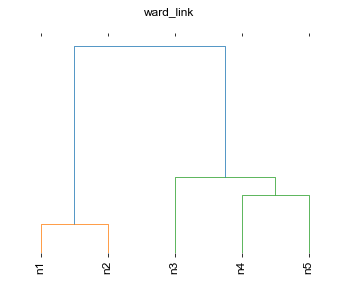

In [36]:
labels = ['n'+str(i+1) for i in range(len(vectors))]
clusterer.dendrogram.draw(title=clusterer.linkage.__name__, labels=labels)

## WPGMA Linkage

In [37]:
clusterer = Clusterer(dist_matrix, linkage='WPGMA')
clusterer.cluster(verbose=2)

k=5
[[        inf  4.         11.70469991 20.         21.54065923]
 [ 4.                 inf  8.06225775 16.         17.88854382]
 [11.70469991  8.06225775         inf  9.8488578   9.8488578 ]
 [20.         16.          9.8488578          inf  8.        ]
 [21.54065923 17.88854382  9.8488578   8.                 inf]]
k=4
[[        inf  9.88347883 18.         19.71460152]
 [ 9.88347883         inf  9.8488578   9.8488578 ]
 [18.          9.8488578          inf  8.        ]
 [19.71460152  9.8488578   8.                 inf]]
k=3
[[        inf  9.88347883 18.85730076]
 [ 9.88347883         inf  9.8488578 ]
 [18.85730076  9.8488578          inf]]
k=2
[[       inf 14.3703898]
 [14.3703898        inf]]


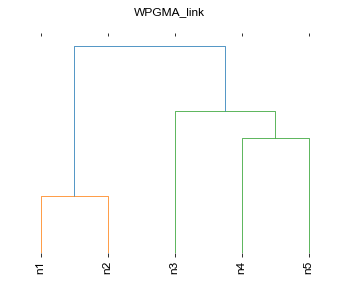

In [38]:
labels = ['n'+str(i+1) for i in range(len(vectors))]
clusterer.dendrogram.draw(title=clusterer.linkage.__name__, labels=labels)

# Clustering using L1 Manhattan Distance

In [39]:
vectors = numpy.array([[4,4], [8,4], [15,8], [24,4], [24,12]])
dist_matrix = DistanceMatrix(vectors, manhattan_distance)

## Single Linkage

In [40]:
clusterer = Clusterer(dist_matrix, linkage='single')
clusterer.cluster(verbose=2)

k=5
[[inf  4. 15. 20. 28.]
 [ 4. inf 11. 16. 24.]
 [15. 11. inf 13. 13.]
 [20. 16. 13. inf  8.]
 [28. 24. 13.  8. inf]]
k=4
[[inf 11. 16. 24.]
 [11. inf 13. 13.]
 [16. 13. inf  8.]
 [24. 13.  8. inf]]
k=3
[[inf 11. 16.]
 [11. inf 13.]
 [16. 13. inf]]
k=2
[[inf 13.]
 [13. inf]]


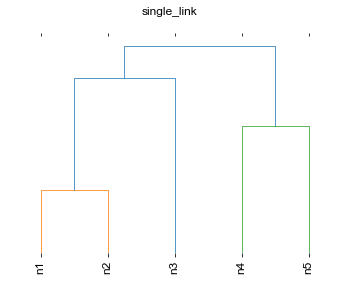

In [41]:
labels = ['n'+str(i+1) for i in range(len(vectors))]
clusterer.dendrogram.draw(title=clusterer.linkage.__name__, labels=labels)

## Complete Linkage

In [42]:
clusterer = Clusterer(dist_matrix, linkage='complete')
clusterer.cluster(verbose=2)

k=5
[[inf  4. 15. 20. 28.]
 [ 4. inf 11. 16. 24.]
 [15. 11. inf 13. 13.]
 [20. 16. 13. inf  8.]
 [28. 24. 13.  8. inf]]
k=4
[[inf 15. 20. 28.]
 [15. inf 13. 13.]
 [20. 13. inf  8.]
 [28. 13.  8. inf]]
k=3
[[inf 15. 28.]
 [15. inf 13.]
 [28. 13. inf]]
k=2
[[inf 28.]
 [28. inf]]


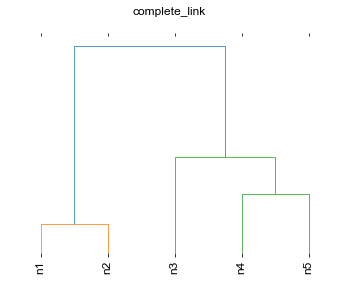

In [43]:
labels = ['n'+str(i+1) for i in range(len(vectors))]
clusterer.dendrogram.draw(title=clusterer.linkage.__name__, labels=labels)

In [44]:
clusterer = Clusterer(dist_matrix, linkage='median')
clusterer.cluster(verbose=2)

k=5
[[inf  4. 15. 20. 28.]
 [ 4. inf 11. 16. 24.]
 [15. 11. inf 13. 13.]
 [20. 16. 13. inf  8.]
 [28. 24. 13.  8. inf]]
k=4
[[inf 12. 17. 25.]
 [12. inf 13. 13.]
 [17. 13. inf  8.]
 [25. 13.  8. inf]]
k=3
[[inf 12. 19.]
 [12. inf 11.]
 [19. 11. inf]]
k=2
[[  inf 12.75]
 [12.75   inf]]


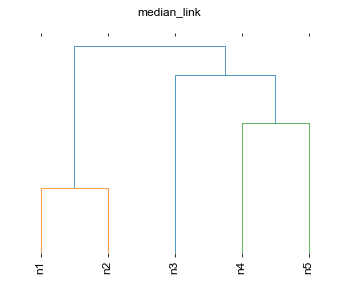

In [45]:
labels = ['n'+str(i+1) for i in range(len(vectors))]
clusterer.dendrogram.draw(title=clusterer.linkage.__name__, labels=labels)

## UPGMA Linkage

In [46]:
clusterer = Clusterer(dist_matrix, linkage='UPGMA')
clusterer.cluster(verbose=2)

k=5
[[inf  4. 15. 20. 28.]
 [ 4. inf 11. 16. 24.]
 [15. 11. inf 13. 13.]
 [20. 16. 13. inf  8.]
 [28. 24. 13.  8. inf]]
k=4
[[inf 13. 18. 26.]
 [13. inf 13. 13.]
 [18. 13. inf  8.]
 [26. 13.  8. inf]]
k=3
[[inf 13. 22.]
 [13. inf 13.]
 [22. 13. inf]]
k=2
[[inf 19.]
 [19. inf]]


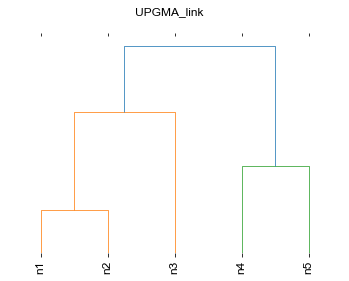

In [47]:
labels = ['n'+str(i+1) for i in range(len(vectors))]
clusterer.dendrogram.draw(title=clusterer.linkage.__name__, labels=labels)

## PDLM Linkage

In [48]:
clusterer = Clusterer(dist_matrix, linkage='PDLM')
clusterer.cluster(verbose=2)

k=5
[[inf  4. 15. 20. 28.]
 [ 4. inf 11. 16. 24.]
 [15. 11. inf 13. 13.]
 [20. 16. 13. inf  8.]
 [28. 24. 13.  8. inf]]
k=4
[[inf 12. 17. 25.]
 [12. inf 13. 13.]
 [17. 13. inf  8.]
 [25. 13.  8. inf]]
k=3
[[inf 12. 19.]
 [12. inf 11.]
 [19. 11. inf]]
k=2
[[        inf 14.22222222]
 [14.22222222         inf]]


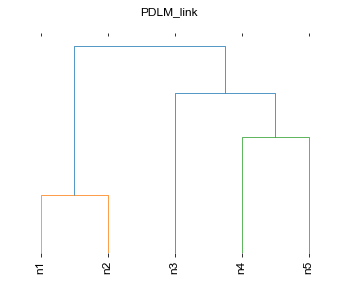

In [49]:
labels = ['n'+str(i+1) for i in range(len(vectors))]
clusterer.dendrogram.draw(title=clusterer.linkage.__name__, labels=labels)

## Ward Linkage

In [50]:
clusterer = Clusterer(dist_matrix, linkage='ward')
clusterer.cluster(verbose=2)

k=5
[[inf  4. 15. 20. 28.]
 [ 4. inf 11. 16. 24.]
 [15. 11. inf 13. 13.]
 [20. 16. 13. inf  8.]
 [28. 24. 13.  8. inf]]
k=4
[[        inf 16.         22.66666667 33.33333333]
 [16.                 inf 13.         13.        ]
 [22.66666667 13.                 inf  8.        ]
 [33.33333333 13.          8.                 inf]]
k=3
[[        inf 16.         38.        ]
 [16.                 inf 14.66666667]
 [38.         14.66666667         inf]]
k=2
[[        inf 34.13333333]
 [34.13333333         inf]]


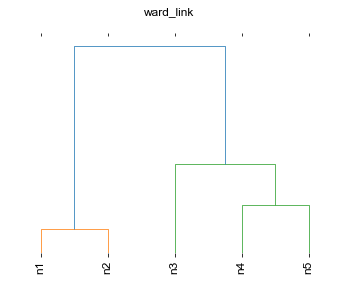

In [51]:
labels = ['n'+str(i+1) for i in range(len(vectors))]
clusterer.dendrogram.draw(title=clusterer.linkage.__name__, labels=labels)

## WPGMA Linkage

In [52]:
clusterer = Clusterer(dist_matrix, linkage='WPGMA')
clusterer.cluster(verbose=2)

k=5
[[inf  4. 15. 20. 28.]
 [ 4. inf 11. 16. 24.]
 [15. 11. inf 13. 13.]
 [20. 16. 13. inf  8.]
 [28. 24. 13.  8. inf]]
k=4
[[inf 13. 18. 26.]
 [13. inf 13. 13.]
 [18. 13. inf  8.]
 [26. 13.  8. inf]]
k=3
[[inf 13. 22.]
 [13. inf 13.]
 [22. 13. inf]]
k=2
[[ inf 17.5]
 [17.5  inf]]


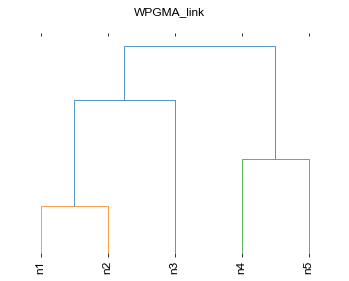

In [53]:
labels = ['n'+str(i+1) for i in range(len(vectors))]
clusterer.dendrogram.draw(title=clusterer.linkage.__name__, labels=labels)

# WPGMA clustering with jaccard_distance

In [54]:
vectors = numpy.array([[4,4], [8,4], [15,8], [24,4], [24,12]])
dist_matrix = DistanceMatrix(vectors, jaccard_distance)
clusterer = Clusterer(dist_matrix, linkage='WPGMA')
clusterer.cluster(verbose=2)

k=5
[[inf 0.5 1.  0.5 1. ]
 [0.5 inf 1.  0.5 1. ]
 [1.  1.  inf 1.  1. ]
 [0.5 0.5 1.  inf 0.5]
 [1.  1.  1.  0.5 inf]]
k=4
[[inf 1.  0.5 1. ]
 [1.  inf 1.  1. ]
 [0.5 1.  inf 0.5]
 [1.  1.  0.5 inf]]
k=3
[[ inf 1.   0.75]
 [1.    inf 1.  ]
 [0.75 1.    inf]]
k=2
[[inf  1.]
 [ 1. inf]]


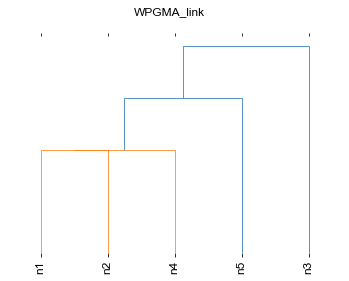

In [55]:
labels = ['n'+str(i+1) for i in range(len(vectors))]
clusterer.dendrogram.draw(title=clusterer.linkage.__name__, labels=labels)

# WPGMA clustering with canberra_distance

In [56]:
vectors = numpy.array([[4,4], [8,4], [15,8], [24,4], [24,12]])
dist_matrix = DistanceMatrix(vectors, canberra_distance)
clusterer = Clusterer(dist_matrix, linkage='WPGMA')
clusterer.cluster(verbose=2)

k=5
[[       inf 0.33333333 0.9122807  0.71428571 1.21428571]
 [0.33333333        inf 0.63768116 0.5        1.        ]
 [0.9122807  0.63768116        inf 0.56410256 0.43076923]
 [0.71428571 0.5        0.56410256        inf 0.5       ]
 [1.21428571 1.         0.43076923 0.5               inf]]
k=4
[[       inf 0.77498093 0.60714286 1.10714286]
 [0.77498093        inf 0.56410256 0.43076923]
 [0.60714286 0.56410256        inf 0.5       ]
 [1.10714286 0.43076923 0.5               inf]]
k=3
[[       inf 0.94106189 0.60714286]
 [0.94106189        inf 0.53205128]
 [0.60714286 0.53205128        inf]]
k=2
[[       inf 0.77410238]
 [0.77410238        inf]]


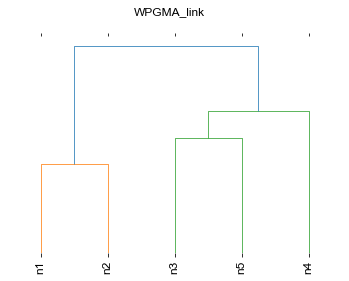

In [57]:
labels = ['n'+str(i+1) for i in range(len(vectors))]
clusterer.dendrogram.draw(title=clusterer.linkage.__name__, labels=labels)

# Conclusion

Implemented linkage clustering algorithms without using python builtin libraries.

Type of clustering algorithms:
- Single
- Complete
- WPGMA
- UPGMA
- Ward
- Mean
- Median
- Medoide
- hausdorff

Type of distances you can use:
- cosine
- L1
- L2
- canberra_distance
- jaccard_distance

In [60]:
vectors = numpy.array([[1,1], [2,0], [1,2], [1,6], [8,0]])
dist_matrix = DistanceMatrix(vectors, manhattan_distance)
clusterer = Clusterer(dist_matrix, linkage='complete')
clusterer.cluster(verbose=2)

k=5
[[inf  2.  1.  5.  8.]
 [ 2. inf  3.  7.  6.]
 [ 1.  3. inf  4.  9.]
 [ 5.  7.  4. inf 13.]
 [ 8.  6.  9. 13. inf]]
k=4
[[inf  3.  5.  9.]
 [ 3. inf  7.  6.]
 [ 5.  7. inf 13.]
 [ 9.  6. 13. inf]]
k=3
[[inf  7.  9.]
 [ 7. inf 13.]
 [ 9. 13. inf]]
k=2
[[inf 13.]
 [13. inf]]


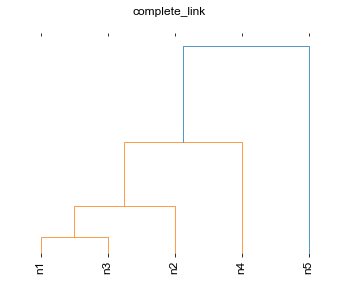

In [61]:
labels = ['n'+str(i+1) for i in range(len(vectors))]
clusterer.dendrogram.draw(title=clusterer.linkage.__name__, labels=labels)